In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score


train = pd.read_csv('train.csv')
greeks = pd.read_csv('greeks.csv')



In [3]:
greeks.describe()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
count,617,617,617,617,617,617
unique,617,4,3,8,4,198
top,000ff2bfdfe9,A,C,M,B,Unknown
freq,1,509,407,445,456,144


In [4]:
print(f"Missing value datatypes in the training dataset")
print(train[train.isna().sum()[train.isna().sum() > 0].index].dtypes)
print("")
print(f"Missing value datatypes in the greeks dataset")
print(greeks[greeks.isna().sum()[greeks.isna().sum() > 0].index].dtypes)

Missing value datatypes in the training dataset
BQ    float64
CB    float64
CC    float64
DU    float64
EL    float64
FC    float64
FL    float64
FS    float64
GL    float64
dtype: object

Missing value datatypes in the greeks dataset
Series([], dtype: object)


In [5]:
for col in train.columns[train.isna().sum()>0]:
    train[col].fillna(train[col].median(),inplace = True)
    

In [6]:
merged = pd.merge(train, greeks, how = 'left', on = 'Id')
merged.head(3)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown


In [7]:
cols_object = merged.columns[merged.dtypes == 'object']
merged[cols_object].head(3)

,Id,EJ,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,B,C,G,D,3/19/2019
1,007255e47698,A,A,C,M,B,Unknown
2,013f2bd269f5,B,A,C,M,B,Unknown


In [8]:
#fazer 1 hot - encode. (dropar o alpha)
'''
le = LabelEncoder()
for col in merged.columns[merged.dtypes == 'object']:
    if col not in ['Id', 'Epsilon']:
        merged[col] = le.fit_transform(merged[col])
        
merged[cols_object].head(3)

#merged = pd.get_dummies(merged, columns=cols_object, drop_first=True)
'''

"\nle = LabelEncoder()\nfor col in merged.columns[merged.dtypes == 'object']:\n    if col not in ['Id', 'Epsilon']:\n        merged[col] = le.fit_transform(merged[col])\n        \nmerged[cols_object].head(3)\n\n#merged = pd.get_dummies(merged, columns=cols_object, drop_first=True)\n"

In [9]:
merged['EJ'] = merged['EJ'].map({'A':0,'B':1})
merged[cols_object].head(3)

,Id,EJ,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,1,B,C,G,D,3/19/2019
1,007255e47698,0,A,C,M,B,Unknown
2,013f2bd269f5,1,A,C,M,B,Unknown


In [10]:

# Columns to be scaled
scl = [col for col in merged.columns if col not in ['Id', 'Class', 'Epsilon']]
scl = [col for col in scl if merged[col].dtypes == 'float64']



In [11]:
from sklearn.preprocessing import StandardScaler
''''''
scaler = StandardScaler()

# Fit and transform the data
merged[scl] = scaler.fit_transform(train[scl])

merged[scl].describe()



,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,...,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02,6.170000e+02
mean,-1.727413e-17,-2.562330e-16,-8.061263e-17,1.727413e-17,-1.597857e-16,-3.699544e-16,2.879022e-17,-8.061263e-17,1.151609e-17,-4.606436e-17,...,-3.253295e-16,-5.758045e-18,2.879022e-18,-2.303218e-17,-2.619910e-16,-1.166004e-16,-1.468301e-16,2.533540e-16,1.439511e-17,2.216847e-16
std,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,...,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00,1.000811e+00
min,-8.460579e-01,-1.439844e+00,-2.616690e-01,-5.137097e-01,-1.892948e-01,-1.900558e+00,-8.341747e-02,-1.649292e+00,-1.047870e-01,-1.211299e+00,...,-2.226608e+00,-4.579251e-01,-6.056579e-02,-2.712413e-01,-1.664964e+00,-4.102598e-01,-7.584606e-01,-2.237869e+00,-1.371168e+00,-8.256053e-01
25%,-4.808509e-01,-5.676274e-01,-2.616690e-01,-3.832006e-01,-1.892948e-01,-5.558782e-01,-8.341747e-02,-5.605707e-01,-1.047870e-01,-3.957384e-01,...,-5.416685e-01,-4.579251e-01,-6.056579e-02,-2.712413e-01,-6.698986e-01,-4.102598e-01,-6.143888e-01,-6.548975e-01,-7.609037e-01,-8.136540e-01
50%,-2.617267e-01,-1.660654e-01,-2.616690e-01,-2.646045e-01,-1.892948e-01,-2.014664e-01,-8.341747e-02,-2.418314e-02,-1.047870e-01,-1.167414e-01,...,-5.649616e-02,-2.091964e-01,-4.792271e-02,-1.308115e-01,-1.956588e-01,-4.102598e-01,-3.537894e-01,-8.936168e-02,-2.642743e-01,-7.929654e-01
75%,1.765216e-01,3.740004e-01,-3.824293e-02,2.459160e-03,-1.892948e-01,3.475245e-01,-5.636569e-02,5.527959e-01,-4.563938e-02,2.270702e-01,...,4.794500e-01,7.039787e-02,-4.032298e-02,8.763478e-02,4.891471e-01,-2.862129e-02,2.252704e-01,5.452616e-01,4.787179e-01,1.304860e+00
max,1.214618e+01,1.095786e+01,1.402509e+01,8.490531e+00,1.606182e+01,1.283533e+01,2.462437e+01,6.534241e+00,2.235522e+01,1.580396e+01,...,8.780034e+00,1.154411e+01,2.474395e+01,2.376305e+01,1.152431e+01,9.479335e+00,6.676769e+00,5.044631e+00,3.880313e+00,1.304860e+00


In [12]:
#predict greeks:

features = train.drop(['Id','Class'],axis = 1).columns.tolist()
target = greeks.drop(['Id','Alpha','Epsilon'],axis = 1).columns.tolist()
x,y = merged[features],merged[target]

print(x.shape)
print(y.shape)
print(y.head(3))
print(y['Beta'].unique())
print(y['Gamma'].unique())
print(y['Delta'].unique())
n_beta = len(y['Beta'].unique())
n_gamma = len(y['Gamma'].unique())
n_delta = len(y['Delta'].unique())


(617, 56)
(617, 3)
  Beta Gamma Delta
0    C     G     D
1    C     M     B
2    C     M     B
['C' 'B' 'A']
['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B']
['D' 'B' 'C' 'A']


In [13]:

y_beta = pd.get_dummies(y['Beta'],prefix='beta')
y_gamma = pd.get_dummies(y['Gamma'],prefix='gamma')
y_delta = pd.get_dummies(y['Delta'],prefix='delta')

print(y_beta.head(2))
print(y_gamma.head(2))
print(y_delta.head(2))

   beta_A  beta_B  beta_C
0       0       0       1
1       0       0       1
   gamma_A  gamma_B  gamma_E  gamma_F  gamma_G  gamma_H  gamma_M  gamma_N
0        0        0        0        0        1        0        0        0
1        0        0        0        0        0        0        1        0
   delta_A  delta_B  delta_C  delta_D
0        0        0        0        1
1        0        1        0        0


In [14]:
# Create the neural network model #beta - (32)(32,15)
                                 #gamma - (64,32)(32,15)
                                 #delta - (64,32)(32,15)
# Split the data into train and validation sets
X_train_beta, X_val_beta, Y_train_beta, Y_val_beta = train_test_split(x.values, y_beta.values, test_size=0.2, random_state=42)

# Define the model architecture
model_beta = Sequential()
model_beta.add(Dense(32, activation='relu', input_shape=(X_train_beta.shape[1],)))
model_beta.add(Dense(Y_train_beta.shape[1], activation='softmax'))

# Compile the model
model_beta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define batch sizes and epochs to iterate over
batch_size = 32
epoch = 15

model_beta.fit(X_train_beta, Y_train_beta, batch_size=batch_size, epochs=epoch, validation_data=(X_val_beta, Y_val_beta))
        

Epoch 1/15
16/16 [==============================] - 0s 8ms/step - loss: 0.9675 - accuracy: 0.2028 - val_loss: 0.8773 - val_accuracy: 0.1694
Epoch 2/15
16/16 [==============================] - 0s 2ms/step - loss: 0.8270 - accuracy: 0.3083 - val_loss: 0.7765 - val_accuracy: 0.2984
Epoch 3/15
16/16 [==============================] - 0s 2ms/step - loss: 0.7162 - accuracy: 0.4422 - val_loss: 0.6988 - val_accuracy: 0.4194
Epoch 4/15
16/16 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.5801 - val_loss: 0.6346 - val_accuracy: 0.5887
Epoch 5/15
16/16 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.6491 - val_loss: 0.5812 - val_accuracy: 0.7016
Epoch 6/15
16/16 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.7079 - val_loss: 0.5385 - val_accuracy: 0.7097
Epoch 7/15
16/16 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.7282 - val_loss: 0.5036 - val_accuracy: 0.7500
Epoch 8/15
16/16 [==

In [15]:
y_pred_prob_beta = model_beta.predict(x.values)
y_pred_beta = np.zeros_like(y_pred_prob_beta)
y_pred_beta[np.arange(len(y_pred_prob_beta)), np.argmax(y_pred_prob_beta, axis=1)] = 1

print(accuracy_score(y_beta,y_pred_beta))

20/20 [==============================] - 0s 797us/step
0.8411669367909238


In [16]:
# Create the neural network model #beta - (32)(32,15)
                                 #gamma - (64,32)(32,15)
                                 #delta - (64,32)(32,15)
# Split the data into train and validation sets
X_train_gamma, X_val_gamma, Y_train_gamma, Y_val_gamma = train_test_split(x.values, y_gamma.values, test_size=0.2, random_state=42)

# Define the model architecture
model_gamma = Sequential()
model_gamma.add(Dense(64, activation='relu', input_shape=(X_train_gamma.shape[1],)))
model_gamma.add(Dense(32, activation='relu'))
model_gamma.add(Dense(Y_train_gamma.shape[1], activation='softmax'))

# Compile the model
model_gamma.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define batch sizes and epochs to iterate over
batch_size = 32
epoch = 15

model_gamma.fit(X_train_gamma, Y_train_gamma, batch_size=batch_size, epochs=epoch, validation_data=(X_val_gamma, Y_val_gamma))
        

Epoch 1/15
16/16 [==============================] - 0s 7ms/step - loss: 0.6561 - accuracy: 0.3063 - val_loss: 0.5610 - val_accuracy: 0.5726
Epoch 2/15
16/16 [==============================] - 0s 2ms/step - loss: 0.4983 - accuracy: 0.6531 - val_loss: 0.4205 - val_accuracy: 0.6935
Epoch 3/15
16/16 [==============================] - 0s 2ms/step - loss: 0.3598 - accuracy: 0.7160 - val_loss: 0.3032 - val_accuracy: 0.6935
Epoch 4/15
16/16 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.7323 - val_loss: 0.2318 - val_accuracy: 0.7097
Epoch 5/15
16/16 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.7383 - val_loss: 0.1997 - val_accuracy: 0.7097
Epoch 6/15
16/16 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.7465 - val_loss: 0.1838 - val_accuracy: 0.7258
Epoch 7/15
16/16 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.7525 - val_loss: 0.1742 - val_accuracy: 0.7661
Epoch 8/15
16/16 [==

In [17]:
y_pred_prob_gamma = model_gamma.predict(x.values)
y_pred_gamma = np.zeros_like(y_pred_prob_gamma)
y_pred_gamma[np.arange(len(y_pred_prob_gamma)), np.argmax(y_pred_prob_gamma, axis=1)] = 1

print(accuracy_score(y_gamma,y_pred_gamma))

20/20 [==============================] - 0s 800us/step
0.8298217179902755


In [18]:
# Create the neural network model #beta - (32)(32,15)
                                 #gamma - (64,32)(32,15)
                                 #delta - (64,32)(32,15)
# Split the data into train and validation sets
X_train_delta, X_val_delta, Y_train_delta, Y_val_delta = train_test_split(x.values, y_delta.values, test_size=0.2, random_state=42)

# Define the model architecture
model_delta = Sequential()
model_delta.add(Dense(64, activation='relu', input_shape=(X_train_delta.shape[1],)))
model_delta.add(Dense(32, activation='relu'))
model_delta.add(Dense(Y_train_delta.shape[1], activation='softmax'))

# Compile the model
model_delta.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define batch sizes and epochs to iterate over
batch_size = 32
epoch = 15

model_delta.fit(X_train_delta, Y_train_delta, batch_size=batch_size, epochs=epoch, validation_data=(X_val_delta, Y_val_delta))
        

Epoch 1/15
16/16 [==============================] - 0s 8ms/step - loss: 0.8169 - accuracy: 0.3225 - val_loss: 0.6509 - val_accuracy: 0.6048
Epoch 2/15
16/16 [==============================] - 0s 3ms/step - loss: 0.5878 - accuracy: 0.6998 - val_loss: 0.4940 - val_accuracy: 0.7419
Epoch 3/15
16/16 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7424 - val_loss: 0.3995 - val_accuracy: 0.7339
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 0.3776 - accuracy: 0.7424 - val_loss: 0.3518 - val_accuracy: 0.7258
Epoch 5/15
16/16 [==============================] - 0s 3ms/step - loss: 0.3353 - accuracy: 0.7424 - val_loss: 0.3297 - val_accuracy: 0.7258
Epoch 6/15
16/16 [==============================] - 0s 4ms/step - loss: 0.3091 - accuracy: 0.7444 - val_loss: 0.3164 - val_accuracy: 0.7339
Epoch 7/15
16/16 [==============================] - 0s 3ms/step - loss: 0.2882 - accuracy: 0.7546 - val_loss: 0.3048 - val_accuracy: 0.7419
Epoch 8/15
16/16 [==

In [19]:
y_pred_prob_delta = model_delta.predict(x.values)
y_pred_delta = np.zeros_like(y_pred_prob_delta)
y_pred_delta[np.arange(len(y_pred_prob_delta)), np.argmax(y_pred_prob_delta, axis=1)] = 1

print(accuracy_score(y_delta,y_pred_delta))

 1/20 [>.............................] - ETA: 0s

20/20 [==============================] - 0s 850us/step
0.8525121555915721


MAKING THE GREEKS --> CLASS MODEL

In [20]:
greeks_data = pd.concat([y_beta, y_gamma, y_delta], axis=1)
greeks_data.head()

,beta_A,beta_B,beta_C,gamma_A,gamma_B,gamma_E,gamma_F,gamma_G,gamma_H,gamma_M,gamma_N,delta_A,delta_B,delta_C,delta_D
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [21]:
greeks_target = train['Class']
print(greeks_data.shape)
print(greeks_target.shape)

(617, 15)
(617,)


In [22]:
# Calculate the class frequencies
class_frequencies = np.bincount(greeks_target)

# Calculate the total number of samples
total_samples = np.sum(class_frequencies)

# Calculate the class weights as the inverse of class frequencies
class_weights = {0: total_samples / (2 * class_frequencies[0]), 1: total_samples / (2 * class_frequencies[1])}

print(class_weights)

{0: 0.6060903732809431, 1: 2.8564814814814814}


In [23]:
#X_greeks_train, X_greeks_val, Y_greeks_train, Y_greeks_val = train_test_split(greeks_data, greeks_target, test_size=0.2, random_state=42)




import xgboost as xgb
from xgboost.callback import EarlyStopping

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import model_selection
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression








config = {'SEED': 42,
          'FOLDS': 14,
          'N_SPLITS': 3,
          'N_ESTIMATORS': 900}

xgb_params = {
    'colsample_bytree': 0.5646751146007976,
    'gamma': 7.788727238356553e-06,
    'learning_rate': 0.1419865761603358,
    'max_bin': 824, 'min_child_weight': 1,
    'random_state': 811996,
    'reg_alpha': 1.6259583347890365e-07,
    'reg_lambda': 2.110691851528507e-08,
    'subsample': 0.879020578464637,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'early_stopping_rounds': 150,
    'n_jobs': -1,
    'verbosity': 0
}

target = ['Class']
#X, y = train.drop(columns=target), train[target[0]]
X = greeks_data
y = greeks_target

cv = model_selection.RepeatedKFold(n_repeats=config['N_SPLITS'], n_splits=config['FOLDS'], random_state=config['SEED'])
feature_importances_ = pd.DataFrame(index=X.columns)
metric = log_loss
eval_results_ = {}
models_ = []
oof = np.zeros(len(X))

for fold, (fit_idx, val_idx) in enumerate(cv.split(X, y), start=1):

    # Split the dataset according to the fold indexes.
    X_fit = X.iloc[fit_idx]
    X_val = X.iloc[val_idx]
    y_fit = y.iloc[fit_idx]
    y_val = y.iloc[val_idx]
    
    # XGB .train() requires xgboost.DMatrix.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.DMatrix
    fit_set = xgb.DMatrix(X_fit, y_fit)
    val_set = xgb.DMatrix(X_val, y_val)
    watchlist = [(fit_set, 'fit'), (val_set, 'val')]

    # Training.
    # https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
    eval_results_[fold] = {}
    model = xgb.train(
        num_boost_round=config['N_ESTIMATORS'],
        params=xgb_params,
        dtrain=fit_set,
        evals=watchlist,
        evals_result=eval_results_[fold],
        verbose_eval=False,
        callbacks=[
            EarlyStopping(xgb_params['early_stopping_rounds'],
                          data_name='val', save_best=True)],
    )
    
    
    val_preds = model.predict(val_set)
    oof[val_idx] += val_preds / config['N_SPLITS']

    val_score = metric(y_val, val_preds)
    best_iter = model.best_iteration
    print(f'Fold: {fold:>3}| {metric.__name__}: {val_score:.5f}'
          f' | Best iteration: {best_iter:>4}')

    # Stores the feature importances
    feature_importances_[f'gain_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='gain'))
    feature_importances_[f'split_{fold}'] = feature_importances_.index.map(model.get_score(importance_type='weight'))

    # Stores the model
    models_.append(model)

mean_cv_score = metric(y, oof)
print(f'{"*" * 50}\nMean {metric.__name__}: {mean_cv_score:.5f}')


Fold:   1| log_loss: 0.00990 | Best iteration:   45
Fold:   2| log_loss: 0.00509 | Best iteration:  106
Fold:   3| log_loss: 0.00949 | Best iteration:   50
Fold:   4| log_loss: 0.01463 | Best iteration:   56
Fold:   5| log_loss: 0.00754 | Best iteration:   49
Fold:   6| log_loss: 0.00576 | Best iteration:  144
Fold:   7| log_loss: 0.00555 | Best iteration:  161
Fold:   8| log_loss: 0.00848 | Best iteration:  524
Fold:   9| log_loss: 0.00665 | Best iteration:   54
Fold:  10| log_loss: 0.00444 | Best iteration:   84
Fold:  11| log_loss: 0.00747 | Best iteration:  139
Fold:  12| log_loss: 0.01035 | Best iteration:   51
Fold:  13| log_loss: 0.00561 | Best iteration:  104
Fold:  14| log_loss: 0.00506 | Best iteration:  307
Fold:  15| log_loss: 0.00736 | Best iteration:  816
Fold:  16| log_loss: 0.00759 | Best iteration:  155
Fold:  17| log_loss: 0.01133 | Best iteration:   55
Fold:  18| log_loss: 0.00716 | Best iteration:   54
Fold:  19| log_loss: 0.00606 | Best iteration:   49
Fold:  20| l

In [25]:
val_preds = model.predict(val_set)
print(val_preds)

[0.00197398 0.00221821 0.01460183 0.01460183 0.01460183 0.00221821
 0.00197398 0.00197398 0.00197398 0.9907478  0.99131155 0.9834119
 0.9907478  0.9818268  0.00197398 0.00197398 0.00197398 0.00304214
 0.00221821 0.00197398 0.00350056 0.01460183 0.00221821 0.00197398
 0.00350056 0.00221821 0.00197398 0.00197398 0.00259332 0.00197398
 0.01460183 0.00197398 0.9907478  0.9930062  0.00221821 0.01460183
 0.00197398 0.00259332 0.00304214 0.00197398 0.00304214 0.00197398
 0.00197398 0.99131155]


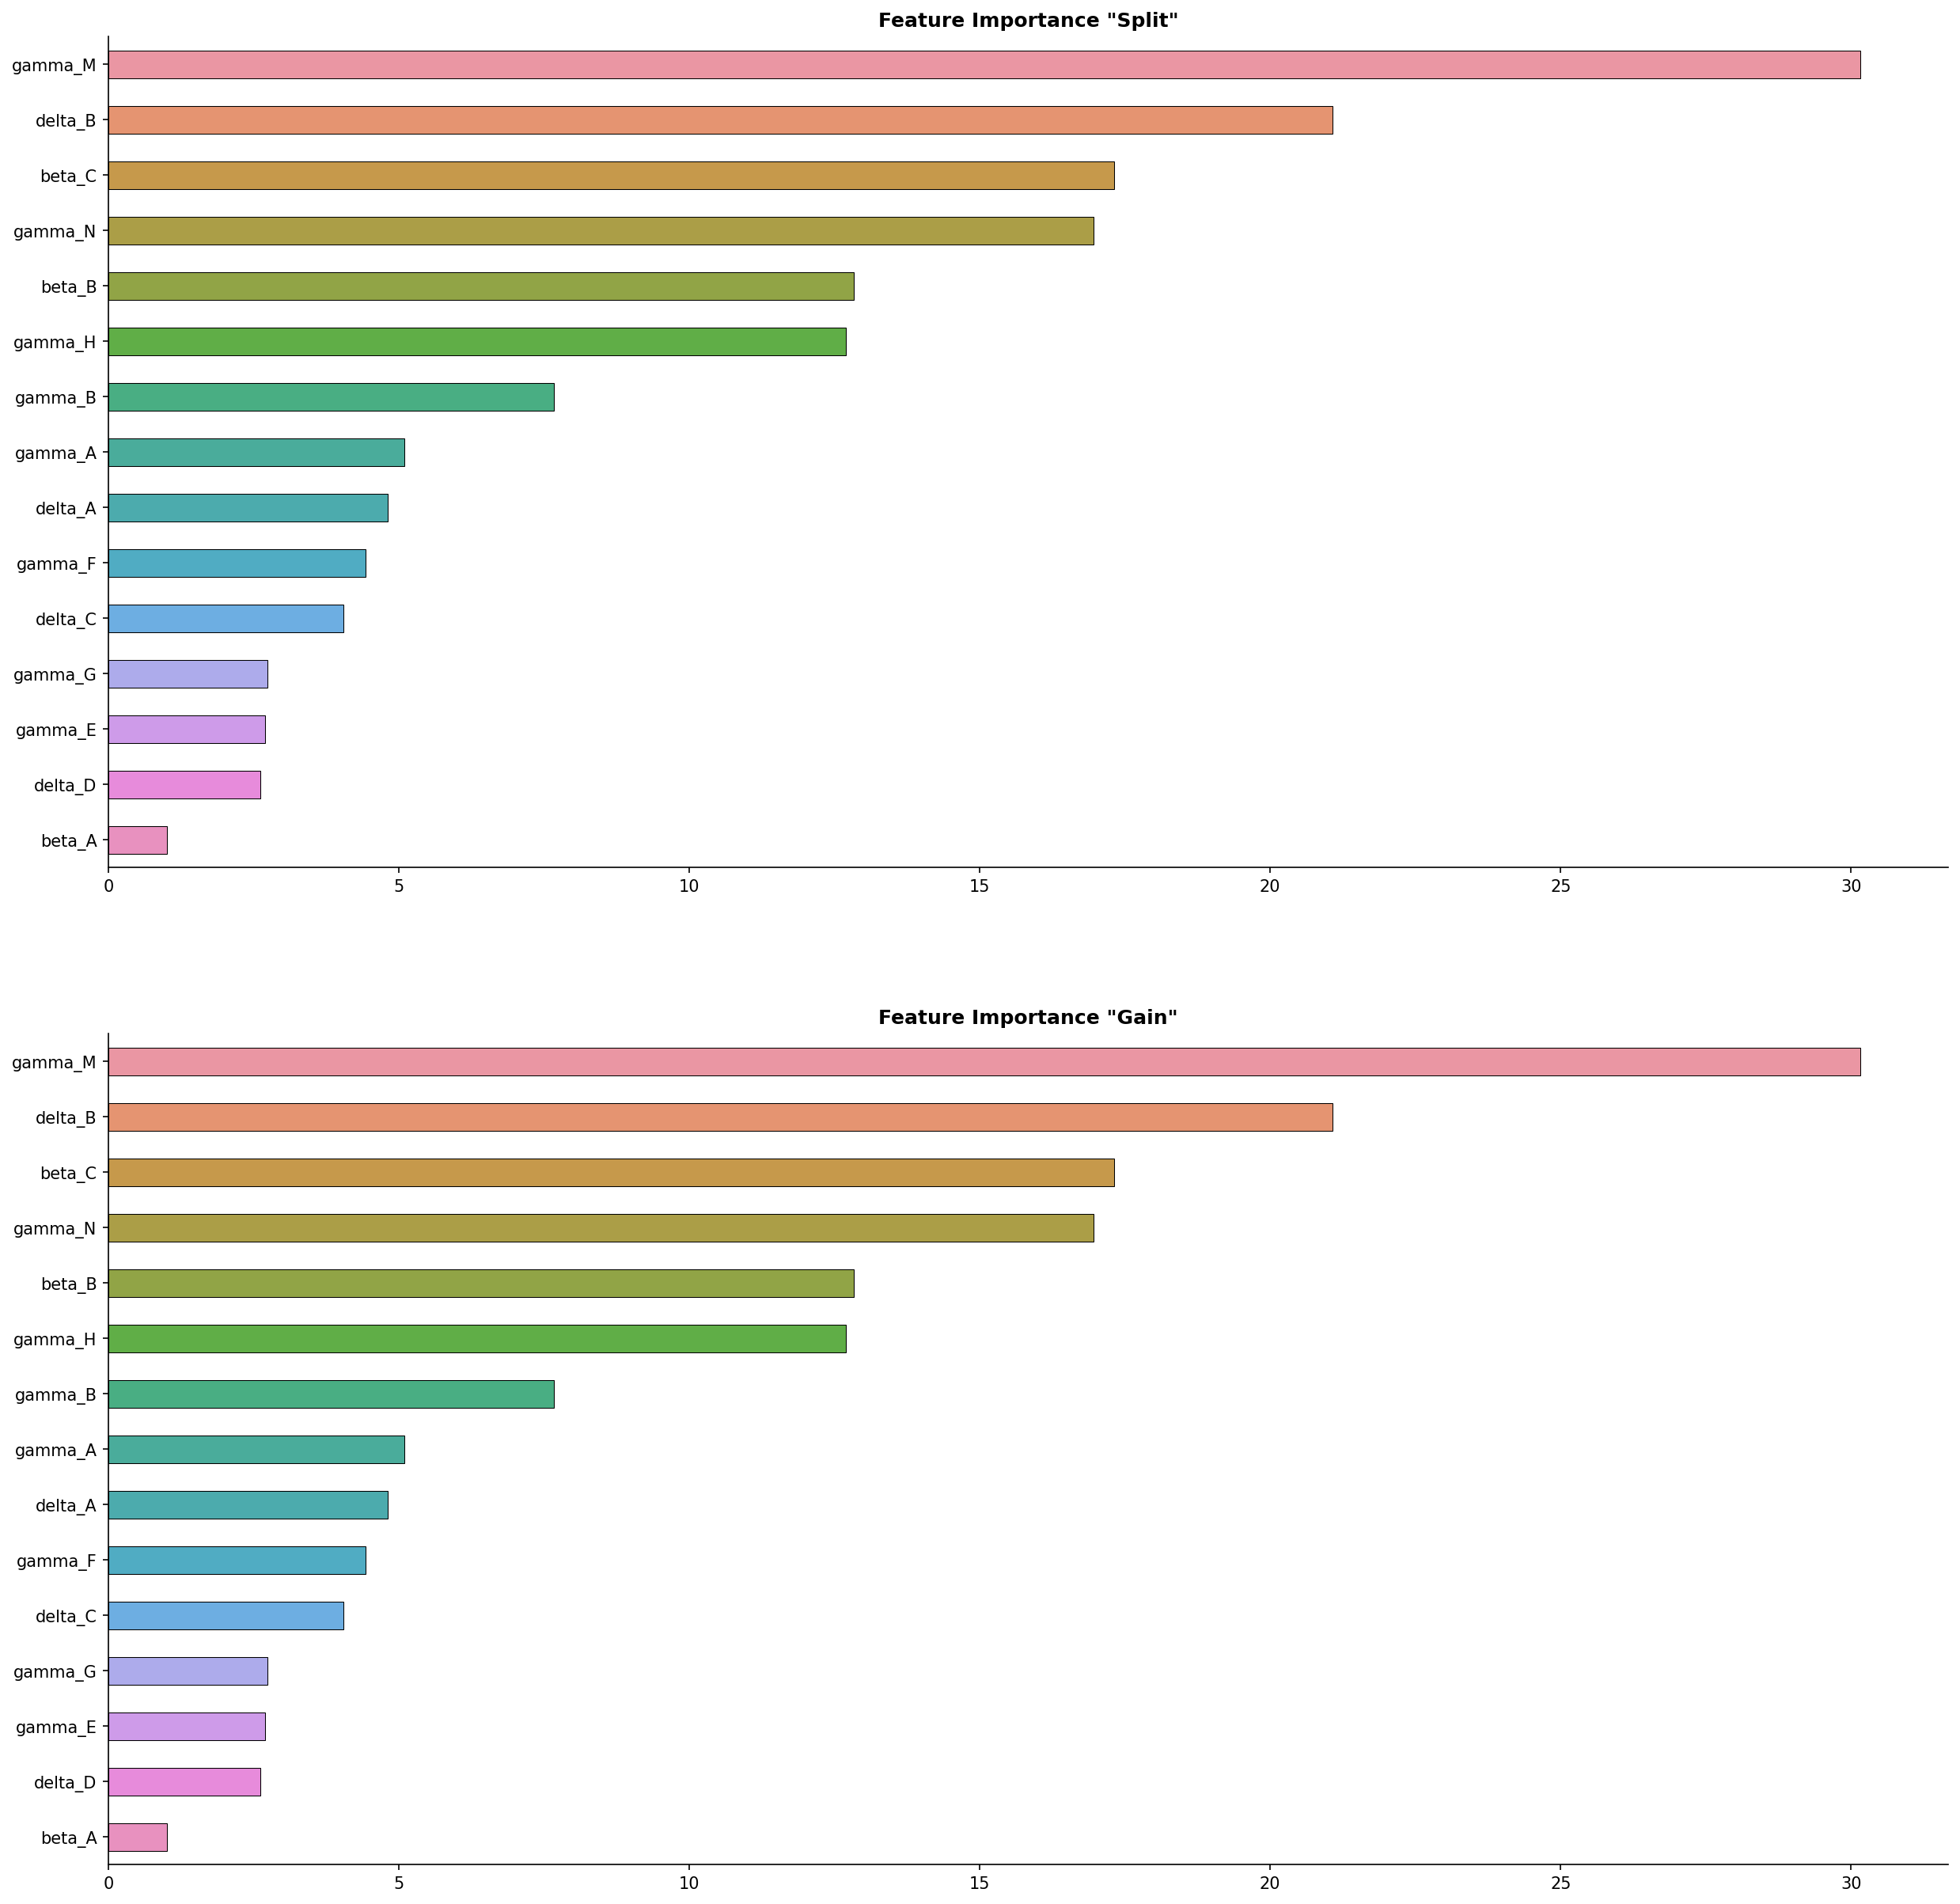

In [ ]:
fi = feature_importances_
fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 20), dpi=150)
ax = ax.flatten()
# Split fi.
data_splt = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_splt.values, y=data_splt.index, 
            linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[0])
ax[0].set_title(f'Feature Importance "Split"', fontdict={'fontweight': 'bold'})
ax[0].set(xlabel=None)

for s in ['right', 'top']:
    ax[0].spines[s].set_visible(False)
ax[0]
# Gain fi.    
data_gain = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_gain.values, y=data_gain.index,
            linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[1])
ax[1].set_title(f'Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
ax[1].set(xlabel=None)

for s in ['right', 'top']:
    ax[1].spines[s].set_visible(False)

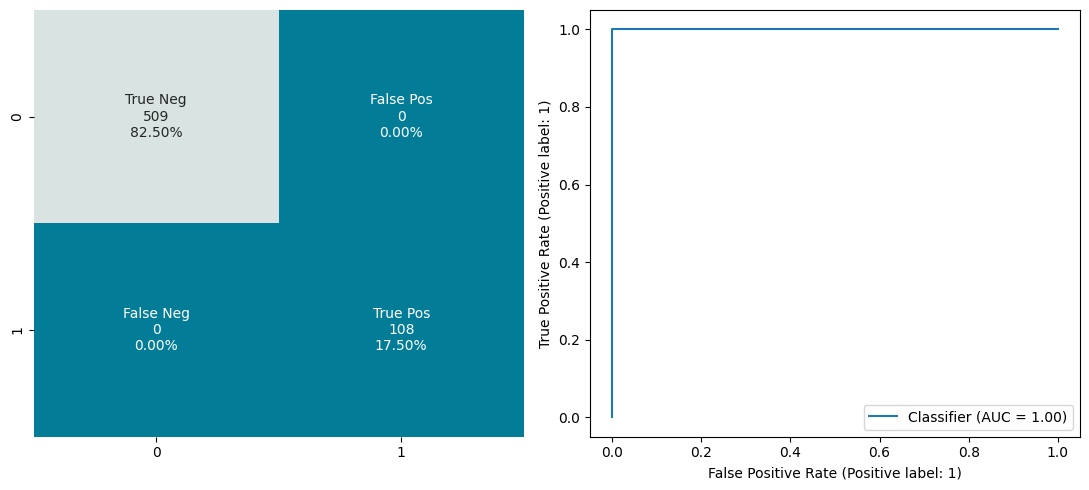

In [ ]:
from sklearn.metrics import confusion_matrix

def show_confusion_logloss(y: pd.Series, oof: list) -> None:
    """Draws a confusion matrix and roc_curve with AUC score.
        
        Args:
            oof: predictions for each fold stacked. (list of tuples)
        
        Returns:
            None
    """
    
    f, ax = plt.subplots(1, 2, figsize=(11, 5))
    df = pd.concat([y, pd.Series(oof)], axis=1)
    df.columns = ['target', 'preds']
    
    # I don't remember the author of the cf_matrix code below, but it deserves kudos.
    oof_cb_rnd = np.where(oof > .50, 1, 0)
    cf_matrix = confusion_matrix(y, (oof_cb_rnd)) 
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=['#037d97', '#90A6B1','#D8E3E2'], cbar=False, ax=ax[0])

    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    plt.tight_layout()

def log_loss(y_true, y_pred):
    return metrics.log_loss(y_true, y_pred)

show_confusion_logloss(y, oof)


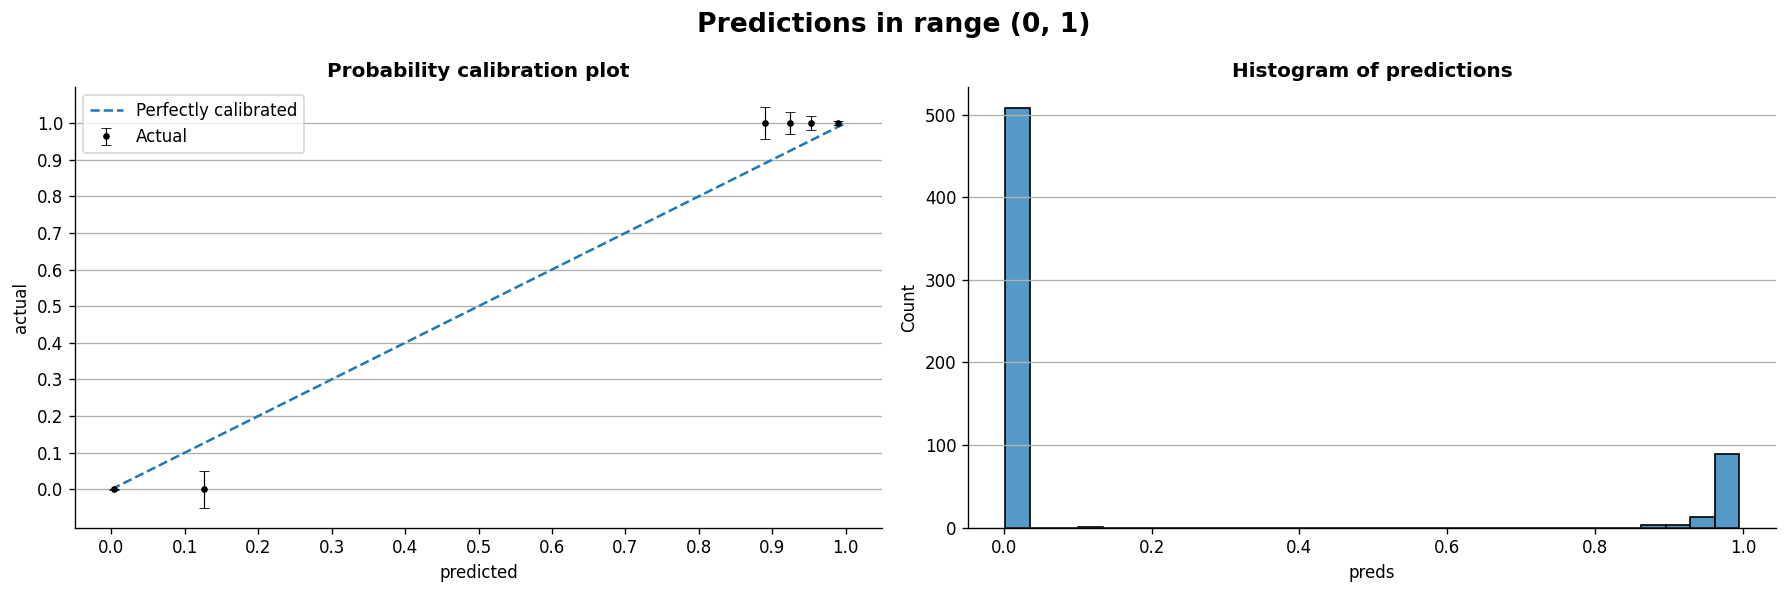

In [ ]:
oof_df = pd.concat([y, pd.Series(oof)], axis=1)
oof_df.columns = ['target', 'preds']

def probability_calibration_plot(y_true=oof_df.target,
                                 y_preds=oof_df.preds,
                                 y_cali=None,
                                 n_bins=30,
                                 yerr_c=0.4,
                                 xylim=1,
                                 tick=0.1,
                                 calib_method=''): 
    
    prob_true, prob_pred = calibration_curve(y_true, y_preds, n_bins=n_bins)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
    ax = ax.flatten()
    ax[0].errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   capthick=0.5, capsize=3, elinewidth=0.7,)

    sns.lineplot(x=np.linspace(0, xylim, 11), y=np.linspace(0, xylim, 11),
                 label='Perfectly calibrated', ax=ax[0], linestyle='dashed')
    
    if isinstance(y_cali, np.ndarray):
        prob_true_, prob_pred_ = calibration_curve(y_true, y_cali, n_bins=n_bins)
        sns.lineplot(x=prob_pred_, y=prob_true_,
                     label=f'{calib_method} Calibration', ax=ax[0], linestyle='solid')
    
    sns.histplot(y_preds, bins=n_bins, ax=ax[1])
    for i, _ in enumerate(ax):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].xaxis.grid(False)
        ax[i].yaxis.grid(True)

    ax[0].set_title(f'Probability calibration plot', fontdict={'fontweight': 'bold'})
    ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'})

    ax[0].set_xticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set_yticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set(xlabel='predicted', ylabel='actual')
    fig.suptitle(f'Predictions in range {(0, xylim)}', ha='center',  fontweight='bold', fontsize=16)
    plt.tight_layout()
    

probability_calibration_plot()

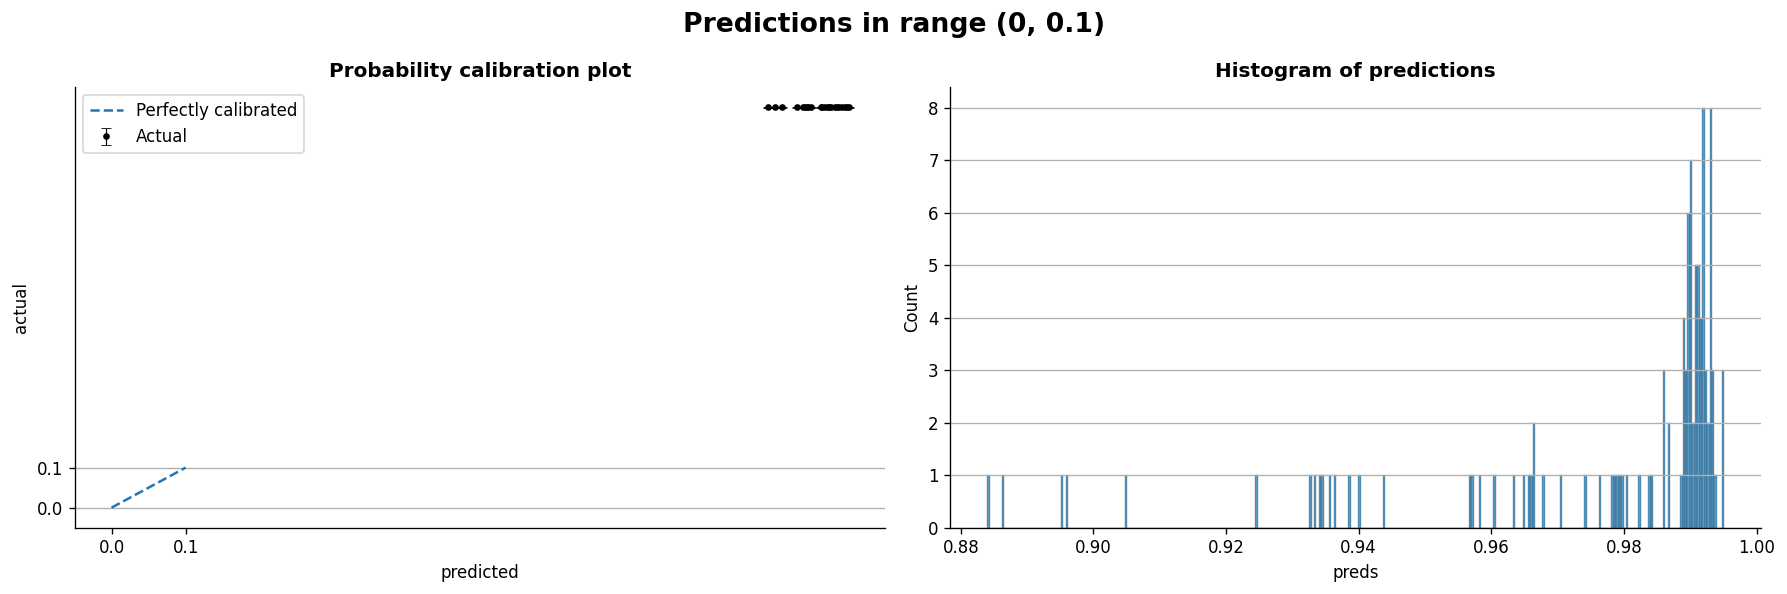

In [ ]:
probability_calibration_plot(y_true=oof_df.query('preds > 0.85').target,
                             y_preds=oof_df.query('preds > 0.85').preds,
                             n_bins=300,
                             yerr_c=0.01,
                             xylim=0.1,
                             tick=0.1)

No calibration LogLoss:       0.00768
Platt calibration LogLoss:    0.00001
Isotonic calibration LogLoss: 0.00000




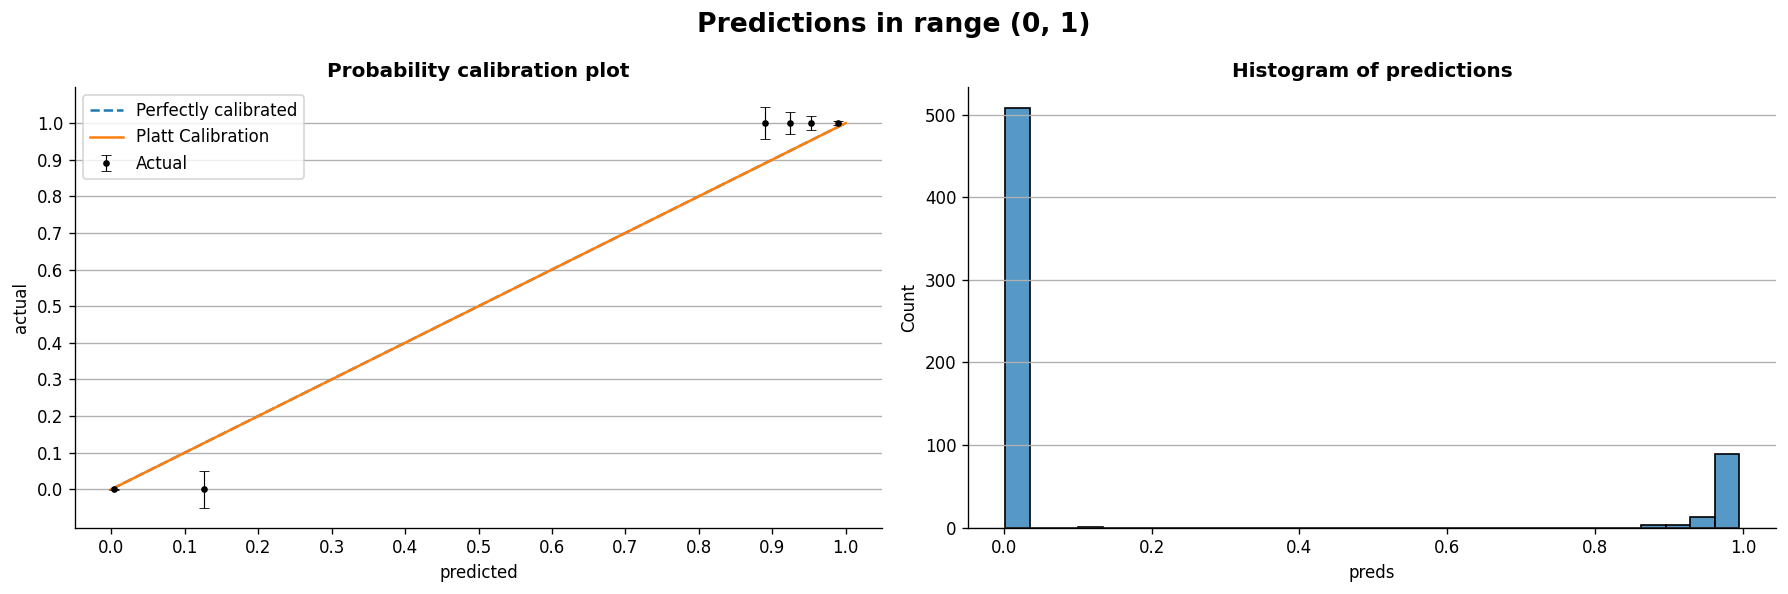

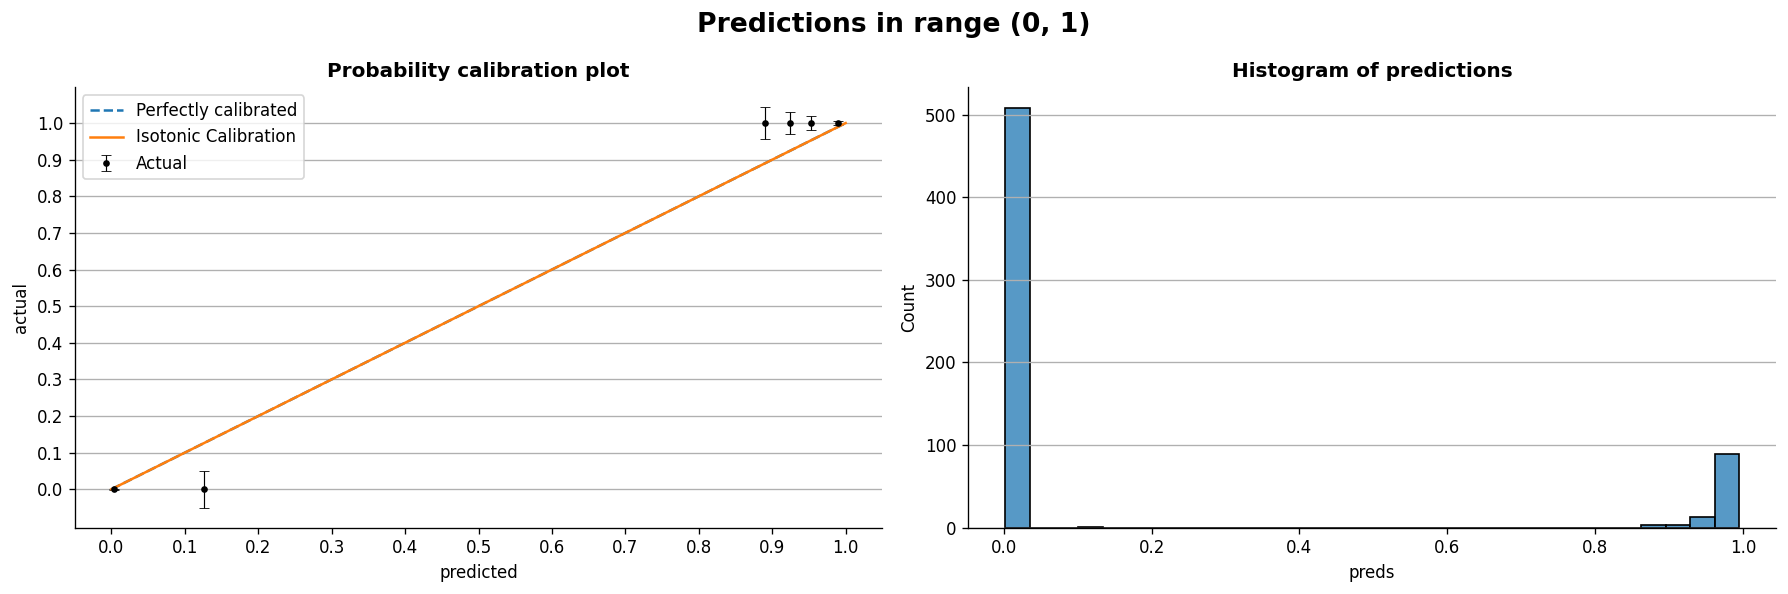

In [ ]:
lr = LogisticRegression(C=99999999999, solver='liblinear', max_iter=1000)
lr.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
lr_preds_calibrated = lr.predict_proba(oof_df.preds.values.reshape(-1, 1))[:,1]
probability_calibration_plot(y_cali=lr_preds_calibrated, calib_method='Platt')

isor = IsotonicRegression(out_of_bounds='clip')
isor.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
isor_preds_calibrated = isor.predict(oof_df.preds.values.reshape(-1, 1))

probability_calibration_plot(y_cali=isor_preds_calibrated, calib_method='Isotonic')
print(f'No calibration LogLoss:       {log_loss(oof_df.target, oof_df.preds):.5f}')
print(f'Platt calibration LogLoss:    {log_loss(oof_df.target, lr_preds_calibrated):.5f}')
print(f'Isotonic calibration LogLoss: {log_loss(oof_df.target, isor_preds_calibrated):.5f}\n\n')

In [ ]:
print(lr.predict_proba(model.predict(xgb.DMatrix(greeks_data)).reshape(-1,1)))

[[4.29143786e-06 9.99995709e-01]
 [9.99995381e-01 4.61859182e-06]
 [9.99995381e-01 4.61859182e-06]
 ...
 [9.99995381e-01 4.61859182e-06]
 [9.99995381e-01 4.61859182e-06]
 [9.99995381e-01 4.61859182e-06]]


In [ ]:
test =   pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv').drop(columns='Id')

def predict(X):
    y = np.zeros(len(X))
    y += model.predict(xgb.DMatrix(X))
    return y

predictions = predict(test)
sub = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
sub['class_1'] = predictions
sub['class_0'] = 1 - predictions
# sub.to_csv('submission.csv',index=False)
sub.head(3)

In [ ]:
y_pred_beta_df = pd.DataFrame(y_pred_beta, columns=['beta_A', 'beta_B', 'beta_C'])
y_pred_gamma_df = pd.DataFrame(y_pred_gamma, columns=['gamma_A', 'gamma_B', 'gamma_E', 'gamma_F', 'gamma_G', 'gamma_H', 'gamma_M', 'gamma_N'])
y_pred_delta_df = pd.DataFrame(y_pred_delta, columns=['delta_A', 'delta_B', 'delta_C', 'delta_D'])

combined_predicted_greek = pd.concat([y_pred_beta_df, y_pred_gamma_df, y_pred_delta_df], axis=1)


combined_predicted_greek.head()

,beta_A,beta_B,beta_C,gamma_A,gamma_B,gamma_E,gamma_F,gamma_G,gamma_H,gamma_M,gamma_N,delta_A,delta_B,delta_C,delta_D
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
predicting_class_from_prediction = model_greeks.predict(combined_predicted_greek)
accuracy_score(train['Class'],predicting_class_from_prediction)

0.8849270664505673

In [ ]:
print(lr.predict_proba(model.predict(combined_predicted_greek)))

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [ ]:
y_pred_prob = model_greeks.predict_proba(combined_predicted_greek)

# Convert the predicted probabilities to a DataFrame
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=model_greeks.classes_)

# Print the predicted probabilities
print(y_pred_prob.shape)

(617, 2)


In [ ]:
binary_predictions = np.zeros_like(y_pred_prob)
binary_predictions[np.arange(len(y_pred_prob)), np.argmax(y_pred_prob, axis=1)] = 1

print(binary_predictions)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
def multiply_by_inverse_sum(row):
    denominator = row[0] + row[1]
    return row * (1 / denominator)


temperature = 2  # Adjust the temperature value as needed

logits = model_greeks.predict_proba(combined_predicted_greek)

# Apply temperature scaling to the logits
scaled_logits = logits / temperature

# Apply softmax to obtain the scaled probabilities
scaled_probabilities = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits), axis=0, keepdims=True)

asd = pd.DataFrame(scaled_probabilities, columns=model_greeks.classes_)

# Applying the function to each row of the DataFrame
result_df = asd.apply(multiply_by_inverse_sum, axis=1)

print(model_greeks.classes_)

result_df.to_csv('output.csv', index=False)


[0 1]


In [ ]:
aux = np.zeros_like(y_pred_prob)
aux[np.arange(len(y_pred_prob)), np.argmax(y_pred_prob, axis=1)] = 1

aux2 = pd.DataFrame(aux)
#y_pred_prob_df.to_csv('output.csv', index=False)


In [ ]:
sub_dict= {
        "Id": train['Id'],
        "class_0": binary_predictions[:, 0],
        "class_1": binary_predictions[:, 1]
        }

submission = pd.DataFrame(sub_dict)
print(submission)

               Id  class_0  class_1
0    000ff2bfdfe9      1.0      0.0
1    007255e47698      1.0      0.0
2    013f2bd269f5      1.0      0.0
3    043ac50845d5      1.0      0.0
4    044fb8a146ec      0.0      1.0
..            ...      ...      ...
612  fd3dafe738fd      1.0      0.0
613  fd895603f071      1.0      0.0
614  fd8ef6377f76      1.0      0.0
615  fe1942975e40      1.0      0.0
616  ffcca4ded3bb      1.0      0.0

[617 rows x 3 columns]


In [ ]:
y_pred_np = model_greeks.predict(combined_predicted_greek)
y_true_np = np.array(train['Class'])

print(accuracy_score(y_pred_np,y_true_np))

0.8849270664505673
